# Random Forest Model using TF/IDF

# Imports and Constants

In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
DATA_PATH = '../data/'
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [34]:
SAVE_MODEL = False

MODEL_PATH = '../models/'
MODEL_FILE_NAME = 'rf_tfidf_model.sav'

# Load Data

In [3]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [4]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [5]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


# Split Data

In [6]:
y = df.label
X = df.drop('label', axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [8]:
X_train.shape

(30910, 4)

In [9]:
X_test.shape

(7728, 4)

# Encode Labels

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)

In [12]:
y_test_enc = le.transform(y_test)

# Train Models

In [13]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## Title & Text only - lowercase, only stopwords, but a larger set of them.

In [14]:
# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

Remove 'via' from the list of stopwords b/c it is particular to this dataset.

In [15]:
expanded_stopwords.remove('via')

In [16]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

In [17]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.97      0.97      0.97     13957
        true       0.97      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



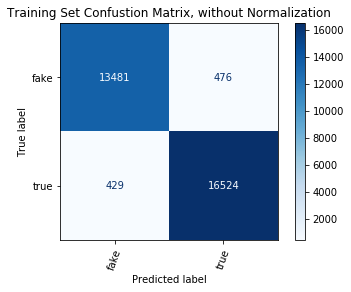

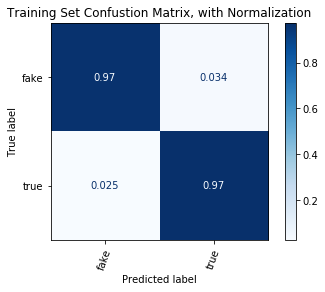

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.92      0.93      3490
        true       0.94      0.95      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



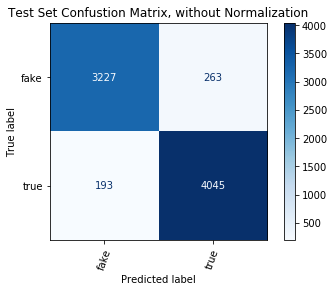

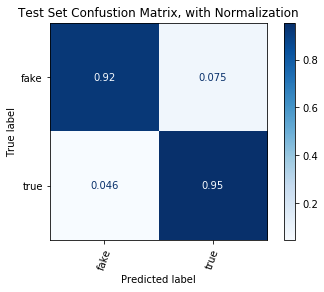

In [18]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [19]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

,importance
said,0.175291
you,0.056869
on,0.055966
just,0.045761
this,0.033416
in,0.028306
here,0.027397
so,0.026242
like,0.024067
is,0.020116


# Save Model

In [32]:
try: 
    os.mkdir(MODEL_PATH)
except FileExistsError:
    print('Model directory already exists')
    pass

In [35]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))

# Summary 

Using tf/idf as features rather than word vectors (BOW) increased the accuracy and F1 scores by a little bit.  This model is the best so far, both as far as its metrics and its ability to generalize.

Using tf/idf rather than BOW should have helped differentiate stories by reducing the importance of some of the commonest stopwords.  Surprisingly the top 5 features didn't change, but after that the order changed and some different words made it into the top 30.